In [1]:
#Library
import requests
import json
from datetime import datetime
import scipy.optimize as optimize
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 1000)
pd.set_option("display.precision", 12)
import warnings
warnings.filterwarnings('once')

In [2]:
def get_data(endpointApi, date=None, full_response=False, columns=list()):
    URL = 'https://dolphin.jump-technology.com:8443/api/v1/'
    AUTH = ('EPITA_GROUPE10', 'LRNSpHqMgGv86AH5')
    
    payload = {'date': date, 'fullResponse': full_response}
    res = requests.get(URL + endpointApi,
                      params=payload,
                      auth=AUTH,
                      verify=False)
    return res.content.decode('utf-8')

In [3]:
def put_data(endpointApi, content):
    URL = 'https://dolphin.jump-technology.com:8443/api/v1/'
    AUTH = ('EPITA_GROUPE10', 'LRNSpHqMgGv86AH5')
    
    res = requests.put(url=URL + endpointApi,
                      data=json.dumps(content),
                      auth=AUTH,
                      headers = {"content-type": "application/json"},
                      verify=False)
    return res.content.decode('utf-8')

In [4]:
def post_data(endpointApi, content):
    URL = 'https://dolphin.jump-technology.com:8443/api/v1/'
    AUTH = ('EPITA_GROUPE10', 'LRNSpHqMgGv86AH5')
    #json.dumps(content),
    res = requests.post(url=URL + endpointApi,
                      data=content,
                      auth=AUTH,
                      headers = {"content-type": "application/json"},
                      verify=False)
    return res.content.decode('utf-8')

Conversion chaque valeur en le type approprié :

In [5]:
def convert_currency(value, df_convert_currency):
    value, currency_name = value.split(' ')
    rate = currencyRateToEUR(currency_name, df_currency_rate)
    
    new_value = float(value.replace(',', '.')) * rate
    return new_value

def convert_datetime(value):
    return datetime.strptime(value, '%Y-%m-%d').date()

def convert_float(value):
    return float(value.replace(',', '.'))

def convert_int(value):
    return int(value)

def convert_boolean(value):
    return json.loads(value)

def df_convert_type(df, df_currency_rate):
        for col in df.columns:
            convert_values = []
            for elt in df[col]:
                if elt is np.nan:
                    convert_values.append(np.nan)
                    continue

                elt_type = elt['type']
                elt_value = elt['value']
                if elt_type == 'currency_value':
                    elt_value = convert_currency(elt_value, df_currency_rate)
                elif elt_type == 'date':
                    elt_value = convert_datetime(elt_value)
                elif elt_type in ['double', 'percent']:
                    elt_value = convert_float(elt_value)
                elif elt_type in ['asset', 'int32']:
                    elt_value = convert_int(elt_value)
                elif elt_type == 'boolean':
                    elt_value = convert_boolean(elt_value)
                elif elt_type not in ['asset_type', 'string', 'asset_currency', 'date-time',
                                     'asset_sub_type', 'asset_status', 'asset_quote_type',
                                     'liquidity_algorithm', 'portfolio_lock_mode', 'portfolio_type']:
                    print(elt)
                convert_values.append(elt_value)
            df[col] = convert_values
        return df

Création de la table des taux en EUR : 
 
[Est-ce qu'on donne la posibilité de changer la currency dst en fonction de la currency du portfolio ?]

In [6]:
def getCurrencyRate():
    d = []
    currency_json = json.loads(get_data('currency'))
    for currency in currency_json:
        currency_id = currency.get('id')
        rate = get_data('currency/rate/{}/to/EUR'.format(currency_id))
        if len(rate) == 0:
            continue
        rate_value = json.loads(rate)['rate']['value']
        d.append([currency_id, convert_float(rate_value)])
    return pd.DataFrame(d, columns=['currency src', 'rate'])
    
df_currency_rate = getCurrencyRate()
df_currency_rate

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,currency src,rate
0,USD,0.851208716377
1,EUR,1.000000000000
2,JPY,0.008066467694
3,BEF,0.024789352477
4,CYP,1.708601441376
...,...,...
23,LUF,0.024789352477
24,VAL,0.000516456899
25,SML,0.000516456899
26,EUr,0.010000000000


[TEST] Taux de convertion entre USD et EUR :

In [7]:
def currencyRateToEUR(cur_src, df_currency_rate):
    return df_currency_rate[df_currency_rate['currency src'] == cur_src]['rate'].values[0]
rate = currencyRateToEUR('USD', df_currency_rate)
rate


0.851208716377

[TEST] La database complète de tous les asset :

In [8]:
data = get_data('asset/')
df = pd.read_json(data)
df_assets = df_convert_type(df, df_currency_rate)
#df_asset_1954 = df_assets[df_assets['ASSET_DATABASE_ID'] == 1954]
#df_asset_1954
df_assets

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,REST_OBJECT_ID,SECTOR,COUNTRY,MARKET_PLACE_CITY,MARKET_PLACE_TYPE,GICS_SUB_INDUSTRY,SUP_SECTOR,VL_DELAY,IS_STRUCTURED_PRODUCT,ASSET_DATABASE_ID,INDEXED_RATE,COUNTRY_CIC,IS_EURONEXT,PORT_CONTENT_COUNT,PAY_ACCOUNT_ON_DEFAULT,LAST_CLOSE_VALUE_IN_CURR,LABEL,CREATION_DATE,IS_DEPOSITARY_QUOTES,IS_FUND_SAVE_SENS,ISIN_CODE,MARKET_PLACE,PORT_LINE_COUNT,CODE_CIC,IS_EUROLAND,REST_UNIQUE_NUMBER,SUB_SECTOR,LIQUIDITY_ALGO,GRAPH_LAST_YEAR,GRAPH_PAST_WEEK,GICS_SECTOR,MARKET_PLACE_CURRENCY,GRAPH_LAST_6_MONTH,asset_custom_classification_bloomberg,LAST_QUOTE_SOURCE,MARKET_PLACE_MIC,ASSET PRICE MODE,GICS_INDUSTRY,IS_PUBLICLY_TRADED,DAILY_PRICE_COUNT,MODIFICATION_DATE,SUB_CATEGORY_CIC,SEDOL_CODE,CURRENCY,FINAL_UNDERLYING,IS_COMPOSITE,UNDERLYING_OR_ASSET_IF_UNDERLYING_NOT_AVAILABLE,MARKET_PLACE_COUNTRY,BLOOMBERG_ID,BLOOMBERG_CODE,GICS_INDUSTRY_GROUP,IS_ACCESSIBILITY_PUBLIC,MARKET_PLACE_TELEKURS,INDUSTRY,TYPE,LAST_CLOSE_VALUE,IS_FUND_FED,QUOTE_TYPE,LAST_QUOTES_UPDATE_DATE,LAST_GROSS_VALUE,ASSET_STATUS,MARKET_CAP_CATEGORY,FINAL_UNDERLYING_TYPE,MARKET_PLACE_OR_ASSET_COUNTRY,CATEGORY_CIC,GRAPH_PAST_YEAR,GRAPH_PERIOD,LAST_QUOTE_DATE,FLOATING_VALUE,GLOBAL_TYPE,quote_value_type,STOCK_TYPE,MARKET_PLACE_DESC,ASSET_OR_MARKET_PLACE_COUNTRY,asset_attr_init,FIRST_QUOTE_DATE,SUB_TYPE,IS_PORTFOLIO,COUNTRY_ISO_3,asset_custom_classification_Tab. de bord GSM,CITY_OR_ACRONYM_OR_NAME,EMIR_CLEARING_ID_TYPE,ELIGIBLE_PEA,ELIGIBLE_PEA_PME,ASSET_MARKET_SUB_GROUP,IS_REAL_ESTATE_FUND,asset_fund_info_isin_code,asset_fund_info_objective_long,asset_fund_info_cut_off,TRANSPARENCY_LIST,asset_fund_info_administrator,asset_fund_info_manager_stated_perf_fee,asset_fund_info_authorized_for_retail_investors,FUND_TYPE,asset_fund_info_creation_date,asset_fund_info_vl_date,asset_fund_info_is_feeded,asset_fund_info_is_euro_ucits,asset_fund_info_asset_class_focus,BOND_YTM_COMPUTATION_MODE,asset_fund_info_maximum_front_end_fee,asset_fund_info_strategy,asset_fund_info_manager_stated_fee,asset_fund_info_valorisation_frequency,asset_fund_info_auditor,BOND_CREDIT_RISK_COMPUTATION_MODE,asset_fund_info_fund_leverage,asset_fund_info_maximum_back_end_fee,BOND_RISK_COMPUTATION_MODE,asset_fund_info_fund_type,BOND_WAM_COMPUTATION_MODE,BOND_WAL_COMPUTATION_MODE,asset_fund_info_minimum_investment_shares,asset_fund_info_bloomberg_ticker,asset_fund_info_company,asset_fund_info_depositary,MIN_BUY_INITIAL_AMOUNT,asset_fund_info_subscription_committee,asset_fund_info_geographical_focus,asset_fund_info_day_cut_off,asset_fund_info_minimum_subscription,MIN_BUY_AMOUNT,asset_fund_info_vl_known,asset_fund_info_pct_max_opcvm,asset_fund_info_initial_minimum_subscription,asset_fund_info_fund_open_pymt_shr,asset_fund_info_amf_date,asset_fund_info_decimalisation,asset_fund_info_amf_classification,asset_fund_info_abide_with_the_four_criterias,asset_fund_info_reuters_code,REUTERS_CODE,asset_fund_info_subscription_frequency,asset_fund_info_redemption_frequency,VALOREN_CODE,asset_fund_info_valoren_code,asset_fund_info_manager,asset_fund_info_redemption_committee,asset_fund_info_advised_horizon,FUND_REF_IDX,asset_fund_info_comanager,HAS_TOBIN_TAX,CUSIP_CODE,LOCAL_CODE,asset_fund_info_rate_entry_sdg,asset_fund_info_rate_output_sdg,asset_fund_info_rate_entry,asset_fund_info_rate_output,asset_fund_info_management_style,MARKET_QUOTE_IDENTIFIER,asset_fund_info_manager_committee,PORT_ASSET_CONTENT_COUNT,INDEX_TYPE,TELEKURS_QUOTE_PLACE_CODE,QUOTE_PLACE,IS_SRD,PORT_NET_EX_CASH_EQUIVALENT,PORT_NET_EX_CASH,EAI_PORT_AVAILABLE_CASH,PORT_CLEAN_MODE,NB_COMPTE_ON_PORTFOLIO,PRICER_MODE,PORT_CASH_EQUIVALENTS,EAI_PORTFOLIO_FEED_NAME,PORT_BASE_NAV,PORT_STATUS,PORT_TYPE,PORT_CURRENCY_HEDGE,PORT_IS_HISTORICAL,PORT_NEED_RECONCILIATION,LOCK_MODE,REAL_TIME_PORT_CASH,PORT_VL,PORT_FEED_TYPE,EAI_FRONTPORT_CASH_BY_CRCY,PORT_CASH_AVAILABLE,PORT_FEED_CODE,EAI_BACKPORT_CASH_BY_CRCY,PORT_CASH,VL_DELAY_VALUE,PORT_RATING_MOODYS_SHORT_TERM,PORT_PERCENT_CASH_AVAILABLE,PORT_RATING_SP_SHORT_TERM,PORT_FIRST_TRANSACTION,PORT_RATING_MOODYS,PORT_RATING_SP,PORT_PERC

Récupération de la liste d'actifs en base :

[On prend juste ces valeurs comme dans l'exemple ou toutes les valeurs des assets ?]

In [9]:
def get_df_asset(asset_date, df_currency_rate, asset_id='ASSET_DATABASE_ID', asset_label='LABEL',
                 asset_type='TYPE', asset_last_close_value='LAST_CLOSE_VALUE_IN_CURR'):
    data = get_data('asset?columns={}&columns={}&columns={}&columns={}&date={}&columns=CREATION_DATE'
                   .format(asset_id, asset_label, asset_type, asset_last_close_value, asset_date))
    df_asset = pd.read_json(data)
    df_asset = df_convert_type(df_asset, df_currency_rate)
    df_asset = df_asset[(df_asset['LAST_CLOSE_VALUE_IN_CURR'].notna()) | (df_asset['TYPE'] == 'PORTFOLIO')].reset_index() #FIXME es assets avec LAST_CLOSE_VALUE_IN_CURR = NAN bug lors de l'ajout dans un portefeuille
    return df_asset

df_ETF = get_df_asset('2016-06-01', df_currency_rate)
df_ETF

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,index,ASSET_DATABASE_ID,LAST_CLOSE_VALUE_IN_CURR,CREATION_DATE,LABEL,TYPE
0,0,1845,36.851000000000,2019-10-02,1&1 DRILLISCH AG,STOCK
1,1,1846,40.900000000000,2019-10-02,1000MERCIS,STOCK
2,2,2122,39.370000000000,2019-10-02,1818-VEGA EUR CO,FUND
3,3,2123,1670.650000000000,2019-10-02,29 HAUSSMANN CROISSANCE EUROPE D,FUND
4,6,1847,31.700000000000,2019-10-02,AALBERTS INDS,STOCK
...,...,...,...,...,...,...
459,475,1879,3.780000000000,2019-10-02,YAMANA GOLD INC,STOCK
460,476,1997,9.460000000000,2019-10-02,YMAGIS SA,STOCK
461,477,1991,1.000000000000,2019-10-02,ZCCM INVESTMEN - B,STOCK
462,478,2106,40.730337078639,2019-10-02,ZOETIS INC,STOCK


Différence entre LAST_CLOSE_VALUE_IN_CURR et LAST_CLOSE_VALUE ??

Récupération des valeurs de cotation:

Cotation de l'actif 1845 en fonction de l'id et de la date de debut et fin :

In [10]:
def get_cotation_values(asset_id, start_date, end_date, df_currency_rate):
    data = get_data('asset/{}/quote?start_date={}&end_date={}'
                    .format(asset_id, start_date, end_date))
    df_cotation = pd.read_json(data)
    df_cotation = df_convert_type(df_cotation, df_currency_rate)
    return df_cotation

df_cotation = get_cotation_values('1845', '2016-06-01', '2020-09-30', df_currency_rate)
df_cotation
    

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,date,nav,gross,volume,high,real_close_price,feed_source,low,ask,asset,pl,bid,close,return,open
0,2016-06-01,36.851000000000,36.851000000000,143199.0,37.125,36.851000000000,-10.0,36.675,36.799,1845,0.037000000000,36.723,36.851000000000,0.001005052426,36.745
1,2016-06-02,36.900000000000,36.900000000000,147480.0,37.145,36.900000000000,-10.0,36.594,36.999,1845,0.049000000000,36.946,36.900000000000,0.001329678978,36.786
2,2016-06-03,36.052000000000,36.052000000000,190934.0,37.200,36.052000000000,-10.0,35.800,36.277,1845,-0.848000000000,36.219,36.052000000000,-0.022981029810,36.900
3,2016-06-06,36.540000000000,36.540000000000,82279.0,36.775,36.540000000000,-10.0,36.082,36.587,1845,0.488000000000,36.534,36.540000000000,0.013536003550,36.190
4,2016-06-07,37.246000000000,37.246000000000,119105.0,37.347,37.246000000000,-10.0,36.470,37.172,1845,0.706000000000,37.150,37.246000000000,0.019321291735,36.590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2020-09-24,27.091248954261,27.091248954261,NaN,NaN,27.091248954261,-10.0,NaN,NaN,1845,-0.550081510430,NaN,27.091248954261,-0.019900688613,NaN
1117,2020-09-25,26.877384954417,26.877384954417,NaN,NaN,26.877384954417,-10.0,NaN,NaN,1845,-0.213863999844,NaN,26.877384954417,-0.007894209684,NaN
1118,2020-09-28,26.634573242213,26.634573242213,NaN,NaN,26.634573242213,-10.0,NaN,NaN,1845,-0.242811712203,NaN,26.634573242213,-0.009034052703,NaN
1119,2020-09-29,26.368478372669,26.368478372669,NaN,NaN,26.368478372669,-10.0,NaN,NaN,1845,-0.266094869544,NaN,26.368478372669,-0.009990581307,NaN


Récupération de la liste des ratios :

In [11]:
def get_ratio(df_currency_rate):
    data = get_data('ratio')
    df_ratio = pd.read_json(data)
    return df_ratio

df_ratio = get_ratio(df_currency_rate)
df_ratio

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,id,type,name,is_benchmark_needed,is_percent
0,11,Ratio,Correlation,True,False
1,7,Ratio,Exposition action,False,True
2,15,Ratio,Exposition action,False,True
3,8,Ratio,RDT,False,True
4,13,Ratio,Rendement,False,True
5,9,Ratio,Rendement_annualise,False,True
6,12,Ratio,Sharpe,False,False
7,14,Ratio,VaR historique,False,True
8,10,Ratio,Volatilite,False,True


Calcul de ratios :

In [12]:
def post_ratio(ratios, assets_id, start_date, end_date, bench=None, frequency=None):
    #start_date = datetime.strptime(start_date, "%Y-%m-%d").isoformat()
    #end_date = datetime.strptime(end_date, "%Y-%m-%d").isoformat()
    
    #payload = {'ratio':ratios, 'asset':assets_id, 'startDate':, 'endDate':None, 'benchmark':bench, 'frequency':frequency}
    payload = "{{'ratio'={},'asset'={},'start_date'={},'end_date'={},'frequency':null}}".format(ratios, assets_id, start_date, end_date)
    reponse = post_data('ratio/invoke', payload)
    return reponse
    
#get Rendement_annualise, Sharpe, Volatilite, Rendement de l'asset 1845 et 1991 entre '2016-06-01' et '2020-09-30'
post_ratio([9, 12, 10, 13], [1845], '2016-06-01', '2020-09-30')

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


'{"1845":{"13":{"type":"percent","value":"-0,297957225027"},"9":{"type":"percent","value":"-0,078330315461"},"12":{"type":"double","value":"-0,285683984949"},"10":{"type":"percent","value":"0,291687038307"}}}'

In [13]:
def get_df_ratios(assets_id, begin_date, end_date):
    json_ratios = json.loads(post_ratio([10, 12, 13], assets_id, begin_date, end_date))
    ratios = []
    for asset_id in assets_id:
        str_asset_id = str(asset_id)
        volatilite = convert_float(json_ratios[str_asset_id]['10']['value'])
        sharpe = convert_float(json_ratios[str_asset_id]['12']['value'])
        rendement = convert_float(json_ratios[str_asset_id]['13']['value'])
        ratios.append([asset_id, volatilite, rendement, sharpe])
    return pd.DataFrame(ratios, columns=['ASSET_DATABASE_ID', 'volatilite', 'rendement', 'sharpe'])

get_df_ratios([1845, 1991], '2016-06-01', '2020-09-30')

,ASSET_DATABASE_ID,volatilite,rendement,sharpe
0,1845,0.291687038307,-0.297957225027,-0.285683984949
1,1991,0.664627044097,0.432487779112,0.122478038159


Recupération du portfolio ID :

In [14]:
def get_portfolio_id(df_assets, label):
    portfolio_id = df_assets.loc[(df_assets['TYPE'] == 'PORTFOLIO') & (df_assets['LABEL'] == label)]['REST_OBJECT_ID'].values[0]
    return int(portfolio_id)



portfolio_id = get_portfolio_id(df_assets, 'EPITA_PTF_10')
portfolio_id_ref = get_portfolio_id(df_assets, 'REF')
print('notre portefeuille id : {}\nréférence portefeuille id : {}'.format(portfolio_id, portfolio_id_ref))

notre portefeuille id : 1829
référence portefeuille id : 2201


Récupération de la composition d’un portefeuille : 

In [15]:
def get_portfolio(portfolio_id):
    data = get_data('portfolio/{}/dyn_amount_compo'.format(portfolio_id))
    df_portfolio = pd.read_json(data)
    return df_portfolio

df_portfolio = get_portfolio(portfolio_id)
df_portfolio

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN


Get assets from portfolio :

In [16]:
def get_assets_portfolio(df_portfolio, date):
    if date not in df_portfolio['values']:
        return np.NaN
    return df_portfolio['values'][date]

#assets = get_assets_portfolio(df_portfolio, '2016-06-01')
#assets

MAJ de la composition d’un portefeuille :


In [17]:
def portfolio_json_assets(assets):
    json = ''
    for asset in assets:
        json += '{{"asset":{{"asset": {}, "quantity": {}}}}},'.format(asset["asset"]["asset"], asset["asset"]["quantity"])
    return json[:-1]
    
def seralize_portfolio_content(df_portfoliot, assets):
    label = df_portfoliot['label'][0]#"EPITA_PTF_10"
    currency = df_portfoliot['currency'][0]#"EUR"
    type_ = df_portfoliot['type'][0]
    date = '2016-06-01' #osef de df_portfolio['date'][0] car cf fiche technique : 
    #"La date de la composition. Pour rappel votre composition doit être unique et doit dater du 2013-06-14"
    assets = portfolio_json_assets(assets) 
    res = '{{"label": "{}", "currency": {{"code": "{}"}}, "type": "{}", "values": {{"{}": [{}]}}}}'.format(label, currency, type_, date, assets)
    return json.loads(res)

def deseralize_portfolio_content(json_portfolio):
    json_portfolio = pd.json_normalize(json_portfolio)
    
    cols = [col for col in json_portfolio.columns if col.split('.')[0] == 'values']
    json_portfolio = json_portfolio[cols]
    json_portfolio.columns = json_portfolio.columns.map(lambda x: x.split(".")[0])

    json_assets = json_portfolio['values'][0]
    assets = []
    for asset in json_assets:
        assets.append(asset)
    return assets


#json_portfolio = seralize_portfolio_content(df_portfolio, assets)
#print(json_portfolio)

#assets = deseralize_portfolio_content(json_portfolio)
#assets

[A CHECK le JSON de put_portfolio]

In [19]:
def put_portfolio(portfolio_id, df_portfolio, assets):
    content = seralize_portfolio_content(df_portfolio, assets)
    print(content)
    put_data('portfolio/{}/dyn_amount_compo'.format(portfolio_id), content)
    
#put_portfolio(portfolio_id, df_portfolio, assets)

In [20]:
df_portfolio = get_portfolio(portfolio_id)
print(df_portfolio['values'].values)
df_portfolio

[nan]


/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN


Reset asset in portfolio :

In [21]:
def reset_assets_portfolio(portfolio_id, df_portfolio):
    content = seralize_portfolio_content(df_portfolio, {})
    content['values'] = {}
    put_data('portfolio/{}/dyn_amount_compo'.format(portfolio_id), content)

    
reset_assets_portfolio(portfolio_id, df_portfolio)

df_portfolio = get_portfolio(portfolio_id)
df_portfolio

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN


Les critiques du MPT soulignent que les rendements ne sont pas normalement distribués et que, par conséquent, l'utilisation de l'écart-type peut ne pas être une bonne mesure de la volatilité.
En outre, un certain nombre de critiques (le plus célèbre étant Warren Buffet) s'opposent à la notion de volatilité comme mesure du risque. La critique contre l'utilisation de la volatilité comme mesure du risque et donc quelque chose à éviter est que la volatilité élevée entraîne également un changement fini pour les rendements des gros portefeuilles. Surtout si les achats d'actifs sont chronométrés sur le marché.

Contraites :

50% d'actions  (en montant pas en quantité)

Le portefeuille doit être exactement composé d’un minimum de 15 actifs, et d’un maximum de 40 actifs.

Attention aux devises :

Vérifier bien la devise dans laquelle est exprimée l’actif.

Avez-vous utilisé le bon taux de conversion pour la devise ?

Avez-vous utilisé le taux dans le bon sens ?

Attention aux quotités:

Votre portefeuille comporte-il bien un nombre entier d’actif ? Ou avez-vous acheté 0.0001 action Total ?

L’actif est-il achetable par unité, dizaine, centaines ? le prix donné est-il un prix par unité, dizaine, centaine ?

Le prix de l’actif est-il exprimé en unité ou en centimes ?

Si vous avez arrondis à postériori les quotités, respectez-vous bien toujours les normes fixées pour le portefeuille ?

[TEST] essaye de trouver les meilleurs actifs et leurs quantités

Merge des cotations de l'asset (asset_id) le 1er jour avec les cotations du dernier jour

Que faisons-nous si la date de début ou de fin de l'asset n'est pas disponible ? on prend un jour avant ? un jour après ?

In [22]:
#SELECTION DES ACTIFS POUR LE PORTFOLIO

Génération de la voile de bateau pour 10 000 portfolios composés de tous les actifs possibles et des quantités aléatoires

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


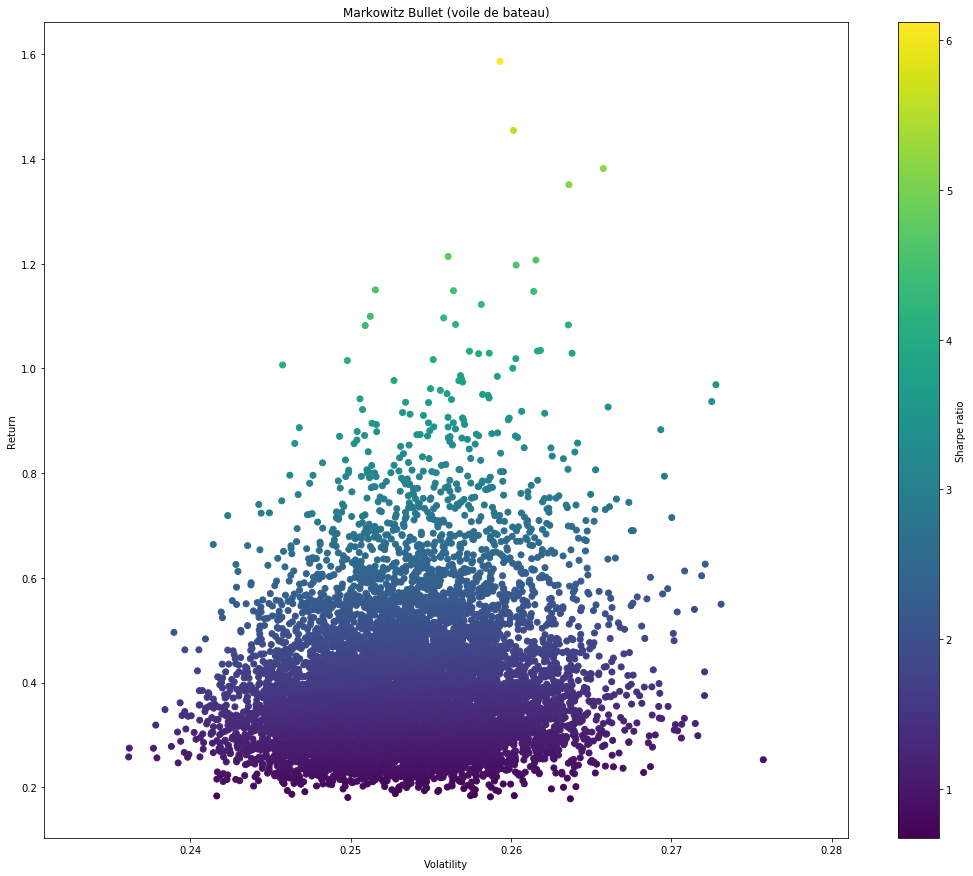

In [23]:
import matplotlib.pyplot as plt
import random
#FIXME pourquoi notre volatilité est très haute et notre rendement est faible ?
#FIXME il faudrait imposer les contraintes du sujet aux portfolios générés (ex: nav 1 et 15%, stock > 50%, ...)
def get_Markowitz_Bullet(begin_date, end_date, best_weights=None, assets=None, iterations=10000):
    if assets is None:
        assets = get_df_asset(begin_date, df_currency_rate)
        assets = assets[assets['TYPE'] != 'PORTFOLIO']
    assets_id = [int(asset_id) for asset_id in assets['ASSET_DATABASE_ID'].values]
    #assets_id = random.choices(assets_id, k=5)
    
    #dataframe de tous les ratio 12 Sharpe 13 Rendement 10 Volatile pour chaque assets
    df_ratios = get_df_ratios(assets_id, begin_date, end_date)
    assets = assets.merge(df_ratios, on='ASSET_DATABASE_ID')
    
    portfolio_returns = []
    portfolio_volatilities = []
    portfolio_sharpes = []
    
    returns = assets['rendement'].values
    volatilities = assets['volatilite'].values
    sharpes = assets['sharpe'].values
    
    for i in range(iterations):
        weights = np.random.dirichlet(np.ones(assets.shape[0]), size=1)
        weights = weights[0]

        total_returns = np.dot(returns, weights)
        total_volatilities = np.dot(volatilities, weights)
        total_sharpes = np.dot(sharpes, weights)
        
        #rates_returns = (1 + returns)**(365/1582) - 1

        #portfolio_sharpes.append((np.sum(rates_returns) - 0.05)/np.sum(total_volatilities))
        #print((np.sum(taux_returns) - 0.05)/np.sum(total_volatilities))
        #print(-(taux_returns - 0.05)/np.dot(volatilities, weights))
        
        portfolio_returns.append(total_returns)
        portfolio_volatilities.append(total_volatilities)
        portfolio_sharpes.append(total_sharpes)
        
    portfolio_returns = np.array(portfolio_returns)
    portfolio_volatilities = np.array(portfolio_volatilities)
    portfolio_sharpes = np.array(portfolio_sharpes)
    
    plt.figure(figsize=(18,15))
    plt.scatter(portfolio_volatilities, portfolio_returns, c = portfolio_returns/portfolio_volatilities)
                #c=(portfolio_sharpes)) #FIXME
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe ratio')
    plt.title('Markowitz Bullet (voile de bateau)')
    
    if best_weights is not None:
        best_portfolio_returns = np.dot(returns, best_weights)
        best_portfolio_volatilies = np.dot(volatilities, best_weights)
        best_sharpe = best_portfolio_returns / best_portfolio_volatilies
        plt.scatter(best_portfolio_volatilies, best_portfolio_returns, c='red', marker='+', s=[500])

        print('Best portfolio have a sharpe ratio = {}'.format(best_sharpe))
    
    #return assets

get_Markowitz_Bullet('2016-06-01', '2020-09-30')

In [24]:
def portfolio_stats(assets, weights):
    returns = assets['rendement'].values
    volatilities = assets['volatilite'].values
    #sharpes = assets['sharpe'].values

    total_returns = np.dot(returns, weights) #FIXME
    total_volatilities = np.dot(volatilities, weights) #FIXME

    #rates_returns = (1 + returns)**(365/1582) - 1
    #portfolio_sharpes.append((np.sum(rates_returns) - 0.05)/np.sum(total_volatilities))

    total_sharpes = total_returns / total_volatilities #FIXME
    
    return {'return': total_returns, 'volatility': total_volatilities, 'sharpe': total_sharpes}

Minimization Functions

In [25]:
def minimize_sharpe(weights, assets):#on veut maximiser sharpe
    return -portfolio_stats(assets, weights)['sharpe'] 

"""def minimize_volatility(weights, assets):#on veut minimiser volatilite
    return portfolio_stats(assets, weights)['volatility']

def minimize_return(weights, assets):#on veut maximiser return
    return -portfolio_stats(assets, weights)['return']"""

"def minimize_volatility(weights, assets):#on veut minimiser volatilite\n    return portfolio_stats(assets, weights)['volatility']\n\ndef minimize_return(weights, assets):#on veut maximiser return\n    return -portfolio_stats(assets, weights)['return']"

The Optimization Function

In [26]:
"""remplace close par nav"""

'remplace close par nav'

In [27]:
assets = get_df_asset('2016-06-01', df_currency_rate)
assets = assets[assets['TYPE'] != 'PORTFOLIO']

assets

,index,LABEL,LAST_CLOSE_VALUE_IN_CURR,CREATION_DATE,ASSET_DATABASE_ID,TYPE
0,0,1&1 DRILLISCH AG,36.851000000000,2019-10-02,1845,STOCK
1,1,1000MERCIS,40.900000000000,2019-10-02,1846,STOCK
2,2,1818-VEGA EUR CO,39.370000000000,2019-10-02,2122,FUND
3,3,29 HAUSSMANN CROISSANCE EUROPE D,1670.650000000000,2019-10-02,2123,FUND
4,6,AALBERTS INDS,31.700000000000,2019-10-02,1847,STOCK
...,...,...,...,...,...,...
459,475,YAMANA GOLD INC,3.780000000000,2019-10-02,1879,STOCK
460,476,YMAGIS SA,9.460000000000,2019-10-02,1997,STOCK
461,477,ZCCM INVESTMEN - B,1.000000000000,2019-10-02,1991,STOCK
462,478,ZOETIS INC,40.730337078639,2019-10-02,2106,STOCK


In [28]:
"""sum_nav_total = 0
for i in range(assets.shape[0]):
    sum_nav_total += weights[i] * assets['LAST_CLOSE_VALUE_IN_CURR'].values[i]
print(sum_nav_total)
l = [weights[x] * assets['LAST_CLOSE_VALUE_IN_CURR'].values[x] for x in range(assets.shape[0])]
for i in range(len(l)):
    if (weights[i] != 0):
        print()
        print('cost {}'.format(assets['LAST_CLOSE_VALUE_IN_CURR'].values[i]))
        print('weights {}'.format(weights[i]))
        print('nav {}'.format(l[i]/sum_nav_total))"""

"sum_nav_total = 0\nfor i in range(assets.shape[0]):\n    sum_nav_total += weights[i] * assets['LAST_CLOSE_VALUE_IN_CURR'].values[i]\nprint(sum_nav_total)\nl = [weights[x] * assets['LAST_CLOSE_VALUE_IN_CURR'].values[x] for x in range(assets.shape[0])]\nfor i in range(len(l)):\n    if (weights[i] != 0):\n        print()\n        print('cost {}'.format(assets['LAST_CLOSE_VALUE_IN_CURR'].values[i]))\n        print('weights {}'.format(weights[i]))\n        print('nav {}'.format(l[i]/sum_nav_total))"

In [29]:
def contraint_nb_assets(x):
    #x = x.round(4)
    #print(x)
    nb_non_zero = np.count_nonzero(x)
    return (15 <= nb_non_zero and nb_non_zero <= 40) - 1
    
def testa(x):
     return (np.sum(x) == 1) and (max(x) < 0.1)

    
def optimize_sharpe(assets):
    nb_assets = assets.shape[0]
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    #,
                    #{'type': 'eq', 'fun': lambda x: contraint_nb_assets(x)})
    #bounds = tuple((0, (weights[x] * assets['LAST_CLOSE_VALUE_IN_CURR'].values[x])) for x in range(nb_assets)) #FIXME entre 0 et 0.15 pas pour les weights
    bounds = tuple((0, 0.15) for x in range(nb_assets)) #FIXME entre 0 et 0.15 pas pour les weights
    #mais pour le nav => 0 <= (w * close) / sum (w * close ) de tous les assets <= 0.15
    #puis on delete tous les w entre 0 et 0.01
    #ps: pour sum (w * close), sum (w) = 1
    initializer = nb_assets * [1 / nb_assets]
    
    best_sharpe = optimize.minimize(minimize_sharpe, initializer, (assets), method='SLSQP', bounds=bounds, constraints=constraints)
    return best_sharpe.x

In [30]:
assets = get_df_asset('2016-06-01', df_currency_rate)
assets = assets[assets['TYPE'] != 'PORTFOLIO']
assets_id = [int(asset_id) for asset_id in assets['ASSET_DATABASE_ID'].values]
#dataframe de tous les ratio 12 Sharpe 13 Rendement 10 Volatile pour chaque assets
df_ratios = get_df_ratios(assets_id, '2016-06-01', '2020-09-30')
assets = assets.merge(df_ratios, on='ASSET_DATABASE_ID').reset_index()



#assets = assets.iloc[:50]
#print(assets.shape)

weights = optimize_sharpe(assets).round(4)
print(np.sum(weights))
print(np.count_nonzero(weights))
print(weights)

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


0.9999999999999999
7
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.

Best portfolio have a sharpe ratio = 49.11775844940928


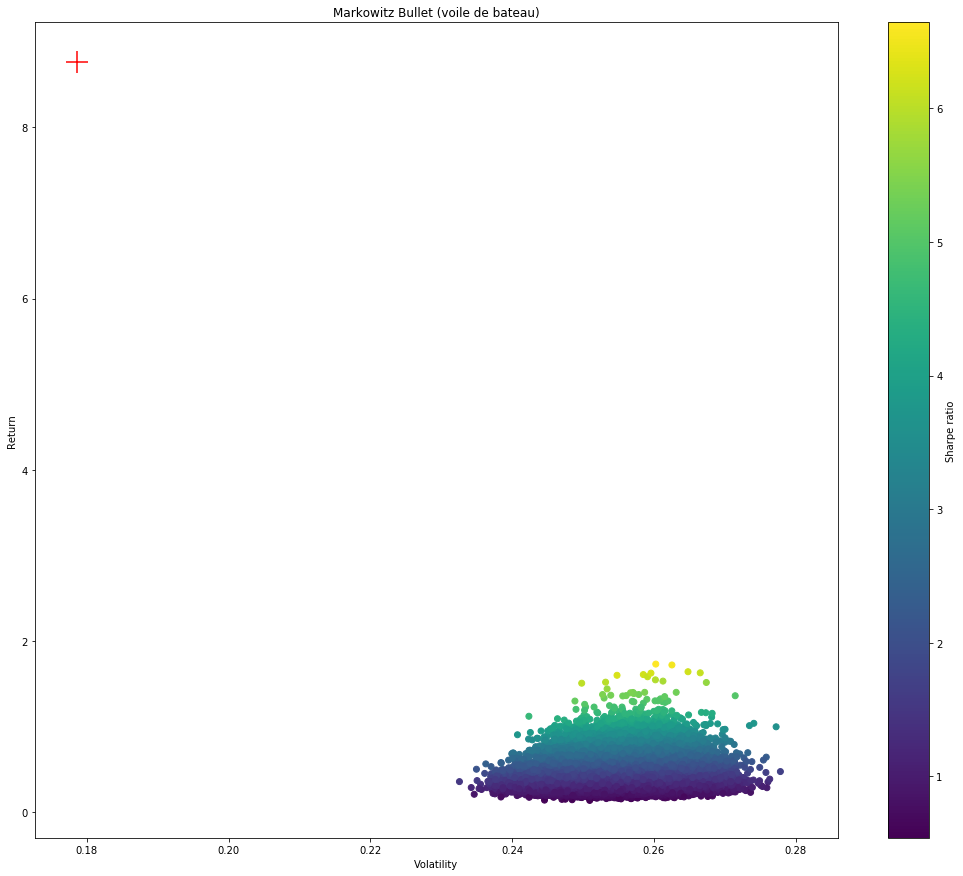

In [31]:
get_Markowitz_Bullet('2016-06-01', '2020-09-30', best_weights=weights, iterations=100000)

In [32]:
np.sum(weights.round(4))

0.9999999999999999

In [33]:
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats

def check_stock_percent_in_assets(assets):
    nb_stocks = assets[assets['TYPE'] == 'STOCK'].shape[0]
    nb_assets = assets.shape[0]
    
    if (nb_stocks / nb_assets) < 0.5:
        print('Error: not enough stock assets !')
        
def check_and_fix_nav_assets(assets, weights):
    sum_nav = 0
    values = assets['LAST_CLOSE_VALUE_IN_CURR'].values
    
    n = len(weights)
    for i in range(n):
        #print(weights[i])
        weights[i] = round(weights[i]*100)#FIXME
        #print(weights[i])
        nav = values[i] * weights[i] #FIXME A CHECK
        sum_nav += nav
    for i in range(n):
        print(values[i])
        print(weights[i])
        nav = values[i] * weights[i]
        nav_asset_part_portfolio = nav / sum_nav
        print('id : {} nav {}'.format(assets['ASSET_DATABASE_ID'].values[i], nav_asset_part_portfolio))

        while nav_asset_part_portfolio < 0.01 or nav_asset_part_portfolio > 0.1:
            nav = values[i] * weights[i]            
            sum_nav -= nav
            
            weights[i] = round(weights[i] * 4.5 / nav_asset_part_portfolio)#FIXME POURQUOI 4.5 ?
            
            nav = values[i] * weights[i]
            sum_nav += nav
            
            nav_asset_part_portfolio = nav / sum_nav
    return weights

def select_best_assets(begin_date, end_date, df_current_rate):
    assets = get_df_asset(begin_date, df_currency_rate)
    #remove portfolios from assets
    assets = assets[assets['TYPE'] != 'PORTFOLIO']
    assets_id = [int(asset_id) for asset_id in assets['ASSET_DATABASE_ID'].values]
    
    #dataframe de tous les ratio 12 Sharpe 13 Rendement 10 Volatile pour chaque assets
    df_ratios = get_df_ratios(assets_id, begin_date, end_date)
    assets = assets.merge(df_ratios, on='ASSET_DATABASE_ID')

    weights = optimize_sharpe(assets).round(4).tolist()
    
    nb_assets = len(assets_id)
    df_assets_weights = pd.DataFrame([(assets_id[i], weights[i]) for i in range(nb_assets)], columns=['ASSET_DATABASE_ID', 'weights'])
    assets = assets.merge(df_assets_weights, on='ASSET_DATABASE_ID')
    
    assets_selected = assets[assets['weights'] != 0]
    
    check_stock_percent_in_assets(assets)#check si stock actifs >= 50%
    
    #CHECK MINIMUM QUANTITY
    #weights = check_and_fix_nav_assets(assets, weights)
    
    #print(np.sum(weights))
    return assets_selected

select_best_assets('2016-06-01', '2020-09-30', df_currency_rate)

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,index,LAST_CLOSE_VALUE_IN_CURR,CREATION_DATE,LABEL,TYPE,ASSET_DATABASE_ID,volatilite,rendement,sharpe,weights
74,82,12.640000000000,2019-10-02,AMUN-CON GL-AEC,FUND,2151,0.104363257803,-0.275350678971,-0.733690549789,0.10
279,293,140.859900000000,2019-08-16,EONIA Total Return Index,INDEX,1521,0.103917880370,0.068529650375,0.100085818639,0.15
284,299,104.000000000000,2019-10-02,ESKER SA,STOCK,2018,0.112442283003,0.176108381041,0.294462435814,0.15
291,306,100.000000000000,2019-10-02,EUROFINS-CEREP REGRP,STOCK,2024,0.559384666198,56.979960623927,2.762250790891,0.15
375,392,10322.150000000000,2019-08-16,LBPAM-EON 3-6-I,FUND,1597,0.111569966021,0.446137575197,0.750922834355,0.15
425,443,3373.425263873689,2019-10-02,S&P 500 Total Return,INDEX,2196,0.120584265610,0.793491619843,1.154264727626,0.15
442,460,1624.310000000000,2019-08-16,SYCOMORE-SY P-IB,FUND,1779,0.112911081413,0.188413980050,0.315331759912,0.15


In [34]:
assets_selected = select_best_assets('2016-06-01', '2020-09-30', df_currency_rate)

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [35]:
def post_assets_selected_in_portfolio(assets, begin_date, df_currency_rate):
    """asset['weights']"""
    assets_id_quantity = [{"asset": {"asset": asset['ASSET_DATABASE_ID'], "quantity": 10000}} for _, asset in assets.iterrows()]
    print(assets_id_quantity)
    df_assets = df_convert_type(pd.read_json(get_data('asset/')), df_currency_rate)
    
    portfolio_id = get_portfolio_id(df_assets, 'EPITA_PTF_10')
    df_portfolio = get_portfolio(portfolio_id)
    
    reset_assets_portfolio(portfolio_id, df_portfolio)#on reset le contenu du portfolio (plus safe)
    
    df_portfolio = get_portfolio(portfolio_id)
    #assets_id_quantity =[{'asset': {'asset': 2112, 'quantity': 18000.0}}, {'asset': {'asset': 2144, 'quantity': 2000.0}}, {'asset': {'asset': 2064, 'quantity': 5000.0}}, {'asset': {'asset': 1968, 'quantity': 90000.0}}, {'asset': {'asset': 1585, 'quantity': 7000.0}}, {'asset': {'asset': 2132, 'quantity': 110.0}}, {'asset': {'asset': 1990, 'quantity': 20000.0}}, {'asset': {'asset': 1897, 'quantity': 35000.0}}, {'asset': {'asset': 2105, 'quantity': 2200.0}}, {'asset': {'asset': 2013, 'quantity': 10000.0}}, {'asset': {'asset': 2142, 'quantity': 650.0}}, {'asset': {'asset': 2143, 'quantity': 420.0}}]
    #put_portfolio(portfolio_id, df_portfolio, assets_id_quantity)
    
#assets_selected = select_best_assets('2016-06-01', '2020-09-30', df_currency_rate)
post_assets_selected_in_portfolio(assets_selected, '2016-06-01', df_currency_rate)

[{'asset': {'asset': 2151, 'quantity': 10000}}, {'asset': {'asset': 1521, 'quantity': 10000}}, {'asset': {'asset': 2018, 'quantity': 10000}}, {'asset': {'asset': 2024, 'quantity': 10000}}, {'asset': {'asset': 1597, 'quantity': 10000}}, {'asset': {'asset': 2196, 'quantity': 10000}}, {'asset': {'asset': 1779, 'quantity': 10000}}]


/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Comparaison du ratio de sharpe entre notre portefeuille et le portefeuille de référence : 

In [36]:
def compare_portfolios(our_portfolio_id, ref_portfolio_id, begin_date, end_date):    
    ratios = json.loads(post_ratio([12], [our_portfolio_id, ref_portfolio_id], begin_date, end_date))
    print('sharpe ratio in our portfolio : {}\nsharpe ratio in ref portfolio : {}'
          .format(ratios[str(our_portfolio_id)]['12']['value'], ratios[str(ref_portfolio_id)]['12']['value']))
    
our_portfolio_id = get_portfolio_id(df_assets, 'EPITA_PTF_10')
ref_portfolio_id = get_portfolio_id(df_assets, 'REF')
compare_portfolios(our_portfolio_id, ref_portfolio_id, '2016-06-01', '2020-09-30')

sharpe ratio in our portfolio : Aucune donnée disponible (pas de donnée d'actif Erreur causée par "EPITA_PTF_10")
sharpe ratio in ref portfolio : -0,337925081462


In [37]:
our_portfolio = get_portfolio(our_portfolio_id)
print(our_portfolio.values)
our_portfolio

[['EPITA_PTF_10' 'EUR' 'front' nan]]


,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN


In [38]:
ref_portfolio = get_portfolio(ref_portfolio_id)
print(ref_portfolio.values)
ref_portfolio

[['REF' 'EUR' 'front' nan]
 ['REF' nan 'front'
  list([{'asset': {'asset': 1860, 'quantity': 6.0}}, {'asset': {'asset': 1900, 'quantity': 10.0}}, {'currency': {'currency': {'code': 'EUR'}, 'amount': 300.0}}])]]


/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,label,currency,type,values
code,REF,EUR,front,NaN
2018-01-01,REF,NaN,front,"[{'asset': {'asset': 1860, 'quantity': 6.0}}, ..."


TODO:

Corriger le calcul du rendement, de la volatilité et du ratio de sharpe

Gérér le nav du portfolio (entre 1 et 15%)

Gérér les quantités des actifs (des entiers et checker la quantité minimum requise pour chaque actif

Minimiser la corrélation dans notre composition d'actifs pour le portfolio

In [39]:
test = get_cotation_values(1846, '2016-06-01', '2020-09-30', df_currency_rate)
test

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,date,nav,gross,volume,high,real_close_price,feed_source,low,ask,asset,pl,bid,close,return,open
0,2016-06-01,40.900000000000,40.900000000000,721.0,41.28,40.900000000000,-10.0,40.90,40.90,1846,-0.100000000000,40.85,40.900000000000,-0.002439024390,41.00
1,2016-06-02,40.910000000000,40.910000000000,98.0,40.91,40.910000000000,-10.0,40.90,41.00,1846,0.010000000000,40.91,40.910000000000,0.000244498778,40.90
2,2016-06-03,40.820000000000,40.820000000000,506.0,40.95,40.820000000000,-10.0,40.60,40.82,1846,-0.090000000000,40.01,40.820000000000,-0.002199951112,40.91
3,2016-06-06,40.700000000000,40.700000000000,454.0,40.83,40.700000000000,-10.0,40.55,40.70,1846,-0.120000000000,40.55,40.700000000000,-0.002939735424,40.83
4,2016-06-07,40.000000000000,40.000000000000,619.0,40.71,40.000000000000,-10.0,39.99,40.00,1846,-0.700000000000,39.80,40.000000000000,-0.017199017199,40.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2020-09-24,26.696705691496,26.696705691496,NaN,NaN,26.696705691496,-10.0,NaN,NaN,1846,-0.367863766495,NaN,26.696705691496,-0.013592079012,NaN
1117,2020-09-25,26.672382171899,26.672382171899,NaN,NaN,26.672382171899,-10.0,NaN,NaN,1846,-0.024323519597,NaN,26.672382171899,-0.000911105658,NaN
1118,2020-09-28,26.566205739084,26.566205739084,NaN,NaN,26.566205739084,-10.0,NaN,NaN,1846,-0.106176432816,NaN,26.566205739084,-0.003980763028,NaN
1119,2020-09-29,26.957723741704,26.957723741704,NaN,NaN,26.957723741704,-10.0,NaN,NaN,1846,0.391518002620,NaN,26.957723741704,0.014737445252,NaN


In [40]:
begin = test[test['date'] == datetime.strptime('2016-06-01', '%Y-%m-%d').date()]
begin

,date,nav,gross,volume,high,real_close_price,feed_source,low,ask,asset,pl,bid,close,return,open
0,2016-06-01,40.9,40.9,721.0,41.28,40.9,-10.0,40.9,40.9,1846,-0.1,40.85,40.9,-0.00243902439,41.0


In [41]:
end = test[test['date'] == datetime.strptime('2016-06-02', '%Y-%m-%d').date()]
end

,date,nav,gross,volume,high,real_close_price,feed_source,low,ask,asset,pl,bid,close,return,open
1,2016-06-02,40.91,40.91,98.0,40.91,40.91,-10.0,40.9,41.0,1846,0.01,40.91,40.91,0.000244498778,40.9


In [42]:
#post_ratio([13, 9, 12, 10], [1845], '2016-06-01', '2017-06-01')

In [43]:
#post_ratio([13, 9, 12, 10], [1845], '2016-06-01', '2016-06-02')

In [44]:
get_ratio(df_currency_rate)

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,id,type,name,is_benchmark_needed,is_percent
0,11,Ratio,Correlation,True,False
1,7,Ratio,Exposition action,False,True
2,15,Ratio,Exposition action,False,True
3,8,Ratio,RDT,False,True
4,13,Ratio,Rendement,False,True
5,9,Ratio,Rendement_annualise,False,True
6,12,Ratio,Sharpe,False,False
7,14,Ratio,VaR historique,False,True
8,10,Ratio,Volatilite,False,True


In [45]:
get_df_asset('2016-06-01', df_currency_rate)

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dolphin.jump-technology.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,index,LABEL,LAST_CLOSE_VALUE_IN_CURR,CREATION_DATE,TYPE,ASSET_DATABASE_ID
0,0,1&1 DRILLISCH AG,36.851000000000,2019-10-02,STOCK,1845
1,1,1000MERCIS,40.900000000000,2019-10-02,STOCK,1846
2,2,1818-VEGA EUR CO,39.370000000000,2019-10-02,FUND,2122
3,3,29 HAUSSMANN CROISSANCE EUROPE D,1670.650000000000,2019-10-02,FUND,2123
4,6,AALBERTS INDS,31.700000000000,2019-10-02,STOCK,1847
...,...,...,...,...,...,...
459,475,YAMANA GOLD INC,3.780000000000,2019-10-02,STOCK,1879
460,476,YMAGIS SA,9.460000000000,2019-10-02,STOCK,1997
461,477,ZCCM INVESTMEN - B,1.000000000000,2019-10-02,STOCK,1991
462,478,ZOETIS INC,40.730337078639,2019-10-02,STOCK,2106


In [ ]:
post_ratio([11], [1845], '2016-06-01', '2019-09-30', bench=1846)